In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt

import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

SNAPSHOTS_DIR = "/pscratch/sd/q/qnicolas/stationarywave_snapshots/"

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


This notebook presents a real-data test of a 12-level sigma model: Gill pattern in the tropics with prescribed DJF basic-state wind, temperature, surface pressure, and sigma velocity. The prescribed heating is as in Ting&Yu, 1998 (eqn. 2,3,4).

The results are not yet perfect (I am not using the same hyperdiffusion and not sure the model has reached a steady state yet) but look quite similar to Ting&Yu, 1998.

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1
kilogram=1.
Pascal = kilogram / meter / second ** 2

# Earth parameters
R0 = 6.4e6*meter
Omega = 2*np.pi/86400 / second
g = 9.81 * meter/second**2
p0 = 1e5 * Pascal

# Getting the ERA5 basic state (DJF 2020)

This next cell requires functions and data that are not present in this folder.
Please adapt to your local setup.

In [70]:
# import os; import sys
# p = os.path.abspath('/global/homes/q/qnicolas/')
# if p not in sys.path:
#     sys.path.append(p)
# from tools.e5tools import *

# def get_djfmean(varcode):
#     return xr.open_dataset(e5_monthly_file(varcode,2020)).groupby("time.season").mean("time").sel(season='DJF').mean('longitude')

# # %%time
# u_djf = get_djfmean('128_131_u').U
# v_djf = get_djfmean('128_132_v').V
# t_djf = get_djfmean('128_130_t').T
# omega_djf = get_djfmean('128_135_w').W
# ps_djf = get_djfmean('128_134_sp').SP
# xr.merge([u_djf,v_djf,t_djf,omega_djf,ps_djf]).to_netcdf("era5_basicstate.nc")


In [110]:
N=12; deltasigma=1/N
sigma = (np.arange(N) + 0.5)*deltasigma

basicstate = xr.open_dataset("era5_basicstate.nc")
basicstate = basicstate.assign_coords(sigma=basicstate.level/basicstate.SP*100)
interp_sigma = lambda sig,y : np.interp(sigma,sig,y)
basicstate_interp = xr.apply_ufunc(interp_sigma,basicstate.sigma,basicstate.drop_vars('SP'),input_core_dims=(('level',),('level',)),output_core_dims=(('sigma',),),vectorize=True)
basicstate_interp = basicstate_interp.assign_coords(sigma=sigma)

xr.merge((basicstate_interp,basicstate.SP)).to_netcdf("era5_basicstate_interp.nc")


# Analysis

In [3]:
snapshot_id = 'stationarywave_12level_T32_realgill'
gill = open_h5s(snapshot_id,('s1','s2'),SNAPSHOTS_DIR=SNAPSHOTS_DIR) #Here, I used one restart, so I need to specifiy the two parts of the output ('s1','s2')
gill = concat_levels(gill ,12)
gill

<xarray.Dataset>
Dimensions:       (longitude: 64, latitude: 32, t: 482, sigma: 12, : 2,
                   sigma_stag: 11)
Coordinates: (12/13)
    phi           (longitude) float64 0.0 0.09817 0.1963 ... 5.989 6.087 6.185
    theta         (latitude) float64 3.068 2.972 2.875 ... 0.2663 0.1698 0.07399
  * t             (t) float64 0.0 1.0 2.0 3.0 4.0 ... 477.0 478.0 479.0 480.0
    sim_time      (t) float64 0.0 1.0 2.0 3.0 4.0 ... 477.0 478.0 479.0 480.0
    wall_time     (t) float64 230.8 243.2 243.9 244.9 ... 513.2 514.6 515.5
    timestep      (t) float64 0.1111 0.1111 0.1111 ... 0.1111 0.1111 0.1111
    ...            ...
    write_number  (t) int64 1 2 3 4 5 6 7 8 ... 475 476 477 478 479 480 481 482
  * longitude     (longitude) float64 -180.0 -174.4 -168.7 ... 163.1 168.7 174.4
  * latitude      (latitude) float64 -85.76 -80.27 -74.74 ... 74.74 80.27 85.76
    day           (t) float64 0.0 0.04167 0.08333 0.125 ... 19.92 19.96 20.0
  * sigma         (sigma) float64 0.04167 0.125 0.2083 ... 0.7917 0.875 0.9583
  * sigma_stag    (sigma_stag) float64 0.08333 0.1667 0.25 ... 0.8333 0.9167
Dimensions without coordinates: 
Data variables:
    Phisfc        (t, longitude, latitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lnps          (t, longitude, latitude) float64 0.0 0.0 ... 6.531e-05
    lnpsbar       (t, longitude, latitude) float64 -0.3198 -0.2295 ... nan nan
    T             (t, longitude, latitude, sigma) float64 0.0 0.0 ... -8.203e-05
    Tbar          (t, longitude, latitude, sigma) float64 236.5 225.7 ... nan
    u             (t, , longitude, latitude, sigma) float64 0.0 ... 6.764e-06
    ubar          (t, , longitude, latitude, sigma) float64 0.001011 ... nan
    zeta          (t, longitude, latitude, sigma) float64 0.0 0.0 ... -0.00011
    sigmadot      (t, longitude, latitude, sigma_stag) float64 0.0 ... 5.541e-06
    sigmadotbar   (t, longitude, latitude, sigma_stag) float64 -3.235e-06 ......

In [19]:
gill_mean = gill.isel(t=slice(400,None)).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

## Basic state

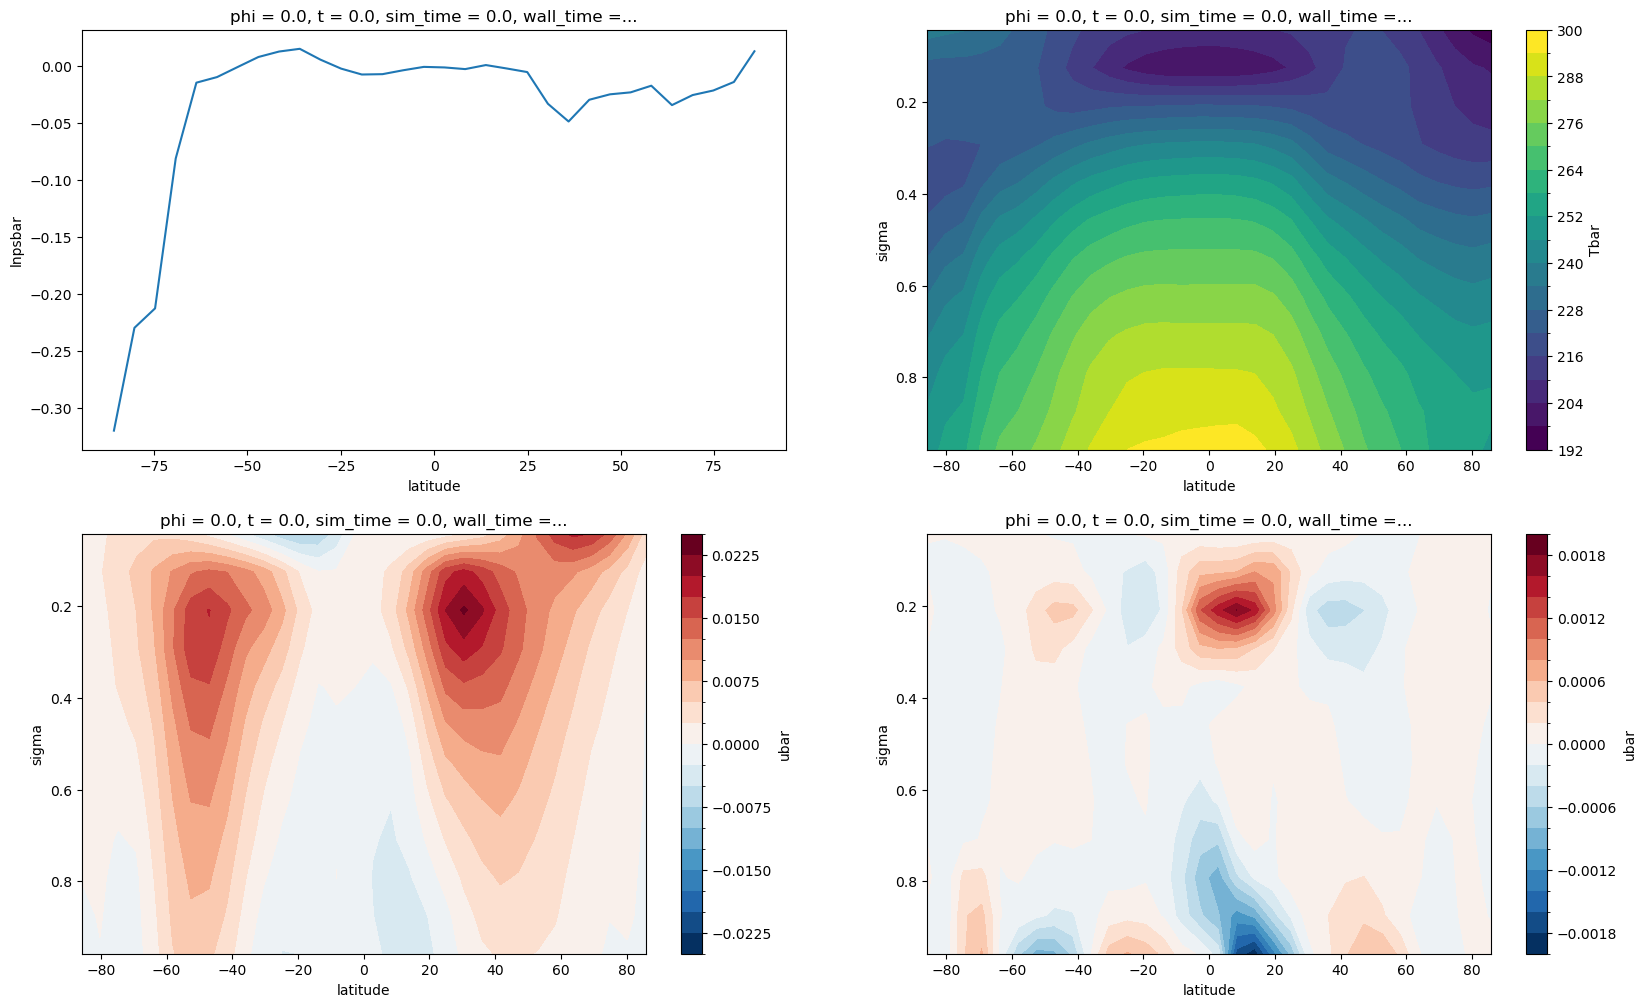

In [8]:
# basic state
_,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
gill_init = gill.isel(t=0,longitude=0)
for i,(ax,var) in enumerate(zip(axs,(gill_init.lnpsbar,gill_init.Tbar,gill_init.ubar[0],-gill_init.ubar[1]))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

## Response

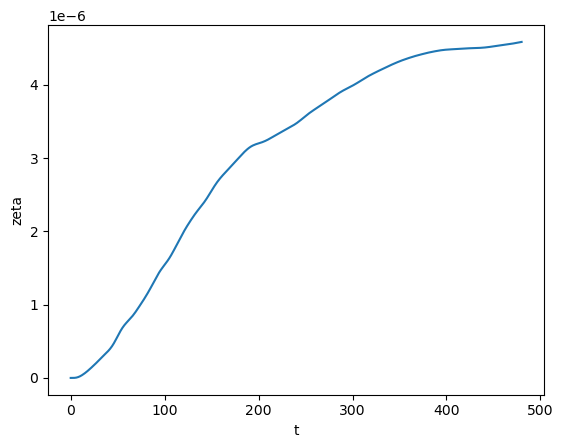

In [18]:
# CONVERGENCE
(gill.zeta**2).mean(('longitude','latitude','sigma')).plot()
#plt.yscale('log')

Text(0.5, 1.0, 'Perturbation vorticity at sigma=0.25 (s^-1)')

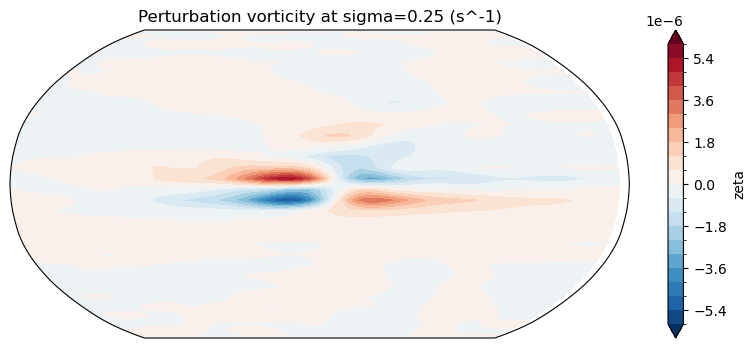

In [20]:
# Perturbation vorticity
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(gill_mean.zeta.sel(sigma=0.75,method='nearest') * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
#plot_heating(ax)
plt.title('Perturbation vorticity at sigma=0.25 (s^-1)')

In [21]:
helm = calc_helmholtz(gill_mean.u,R0)

2024-07-19 16:47:23,828 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+02/s
2024-07-19 16:47:23,838 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+02/s
2024-07-19 16:47:23,851 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+02/s
2024-07-19 16:47:23,864 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+02/s
2024-07-19 16:47:23,877 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+02/s
2024-07-19 16:47:23,890 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+02/s
2024-07-19 16:47:23,903 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+02/s
2024-07-19 16:47:23,916 subsystems 0/1 INFO :: Building subproblem matric

In [27]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')


Text(0.5, 1.0, 'Streamfunction and rotational wind at sigma=0.8\n compare with Ting&Yu 1998 Fig. 4b ')

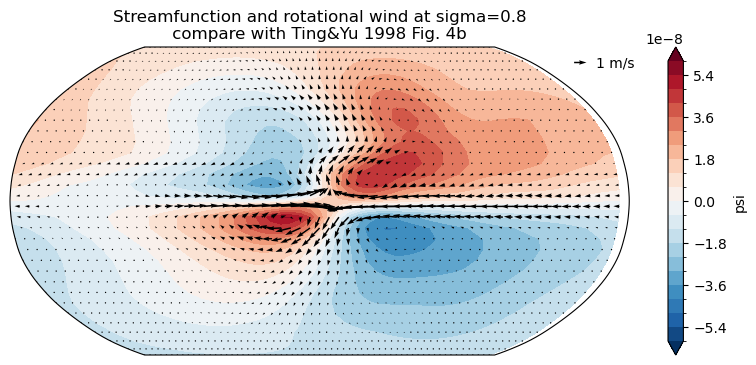

In [29]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
sig=0.8
(helm.psi.sel(sigma=sig,method='nearest') * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (helm.u_rot[0].sel(sigma=sig,method='nearest'))/(meter/second)
v=-(helm.u_rot[1].sel(sigma=sig,method='nearest'))/(meter/second)
add_wind(ax,u,v,scale=50)
plt.title('Streamfunction and rotational wind at sigma=%.1f\n compare with Ting&Yu 1998 Fig. 4b '%sig)

Text(0.5, 1.0, 'Streamfunction and rotational wind at sigma=0.2\n compare with Ting&Yu 1998 Fig. 4a ')

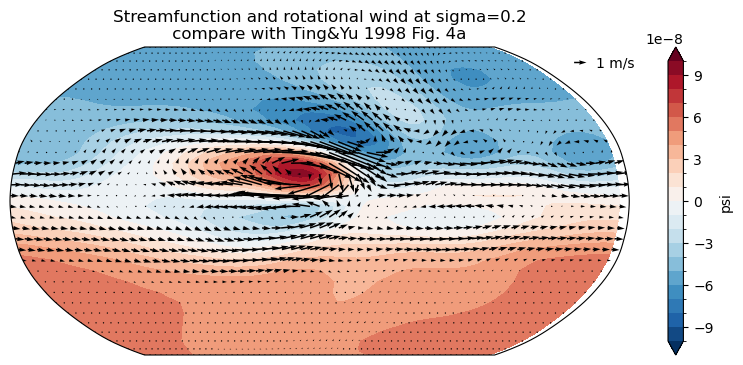

In [30]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
sig=0.25
(helm.psi.sel(sigma=sig,method='nearest') * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (helm.u_rot[0].sel(sigma=sig,method='nearest'))/(meter/second)
v=-(helm.u_rot[1].sel(sigma=sig,method='nearest'))/(meter/second)
add_wind(ax,u,v,scale=50)

plt.title('Streamfunction and rotational wind at sigma=%.1f\n compare with Ting&Yu 1998 Fig. 4a '%sig)

Text(0.5, 1.0, 'Divergence and full wind at sigma=0.80 ')

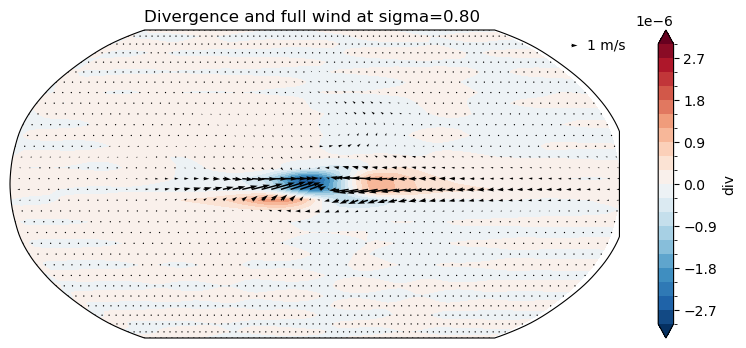

In [33]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})

sig=0.8
(helm.div.sel(sigma=sig,method='nearest') * second).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())

u= (gill_mean.u[0].sel(sigma=sig,method='nearest'))/(meter/second)
v=-(gill_mean.u[1].sel(sigma=sig,method='nearest'))/(meter/second)
add_wind(ax,u,v,scale=100)

plt.title('Divergence and full wind at sigma=%.2f '%sig)